
---
### What is CCT, and why do we use it?

---

**CCT** stands for **Compact Convolutional Transformer**. It is a powerful architecture used in **Computer Vision** problems because it combines the best features of **transformers** and **convolutional neural networks (CNNs)**.

---

##### Key Features of CCT:
- In **Vision Transformer (ViT)**, patches are required. But in **CCT**, the model starts by using **convolutional layers**.
  - These layers extract important features from images, such as **edges** and **textures**.
  - This helps in representing images better and ensures that the model can capture **local patterns** from the image.
  
- After the convolutional layers, **pooling** is required to reshape the images.
  - This reshaped output works as a sequence for the **transformer model**.
  
- **Positional embedding** is usually needed for patches in **ViT**, but in **CCT**, positional embedding is optional.
  - This is because the reshaped image already contains enough information for the transformer encoder.
  
---

##### Transformer Encoder in CCT:

- The **Transformer Encoder** processes the sequence of image tokens (small pieces of the image) and learns how they relate to each other.
- It captures both **local** and **global** patterns in the image.
- The **self-attention** mechanism allows each token to look at every other token in the image and identify the important relationships.
- This helps the model understand how different parts of the image, such as edges and textures, interact.
  
---

##### Sequence Pooling in CCT:

- After the transformer encoder processes the tokens, **Sequence Pooling** gathers information from all tokens and creates a **single, condensed representation** of the entire image.
- The pooled representation is an average (or sum) of all tokens, which is used for classification.
- This step effectively summarizes the whole image into **one vector**, enabling the model to classify the image without needing to focus on individual patches anymore.

---

##### MLP Head in CCT:

- The **MLP Head** (Multilayer Perceptron) is the final part of the model.
  - It takes the pooled representation from sequence pooling and predicts the class of the image (e.g., t-shirt, shoe, etc.).
  - The MLP Head is a simple, fully connected neural network made up of one or more layers of neurons.
  - These neurons process the pooled image representation and output the final prediction, like a 90% chance that the image is a "t-shirt".
  
---

##### Summary:
- **CCT** is particularly effective for **small datasets**, as it uses convolution to extract local features and combines it with transformers to understand **global relationships** within the image.
- This gives it a strong ability to **recognize complex visual patterns**.
- **ViT**, on the other hand, works well with **large datasets**.


![alt text](model_sym.png)

![alt text](comparison.png)

##### Now that we got a grip on CCT basics, we are going to implement CCT on the FashionMnist dataset.

- At First we will import the necessary libraries and load the dataset


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Load the FashionMNIST dataset with normalization
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Download the training dataset
full_train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



In [4]:
# Split into training (90%) and validation (10%)
train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

In [5]:
# Load the datasets into DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)

In [6]:
# Load the test dataset (which is kept aside for evaluation only)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

Sample images from the training set:


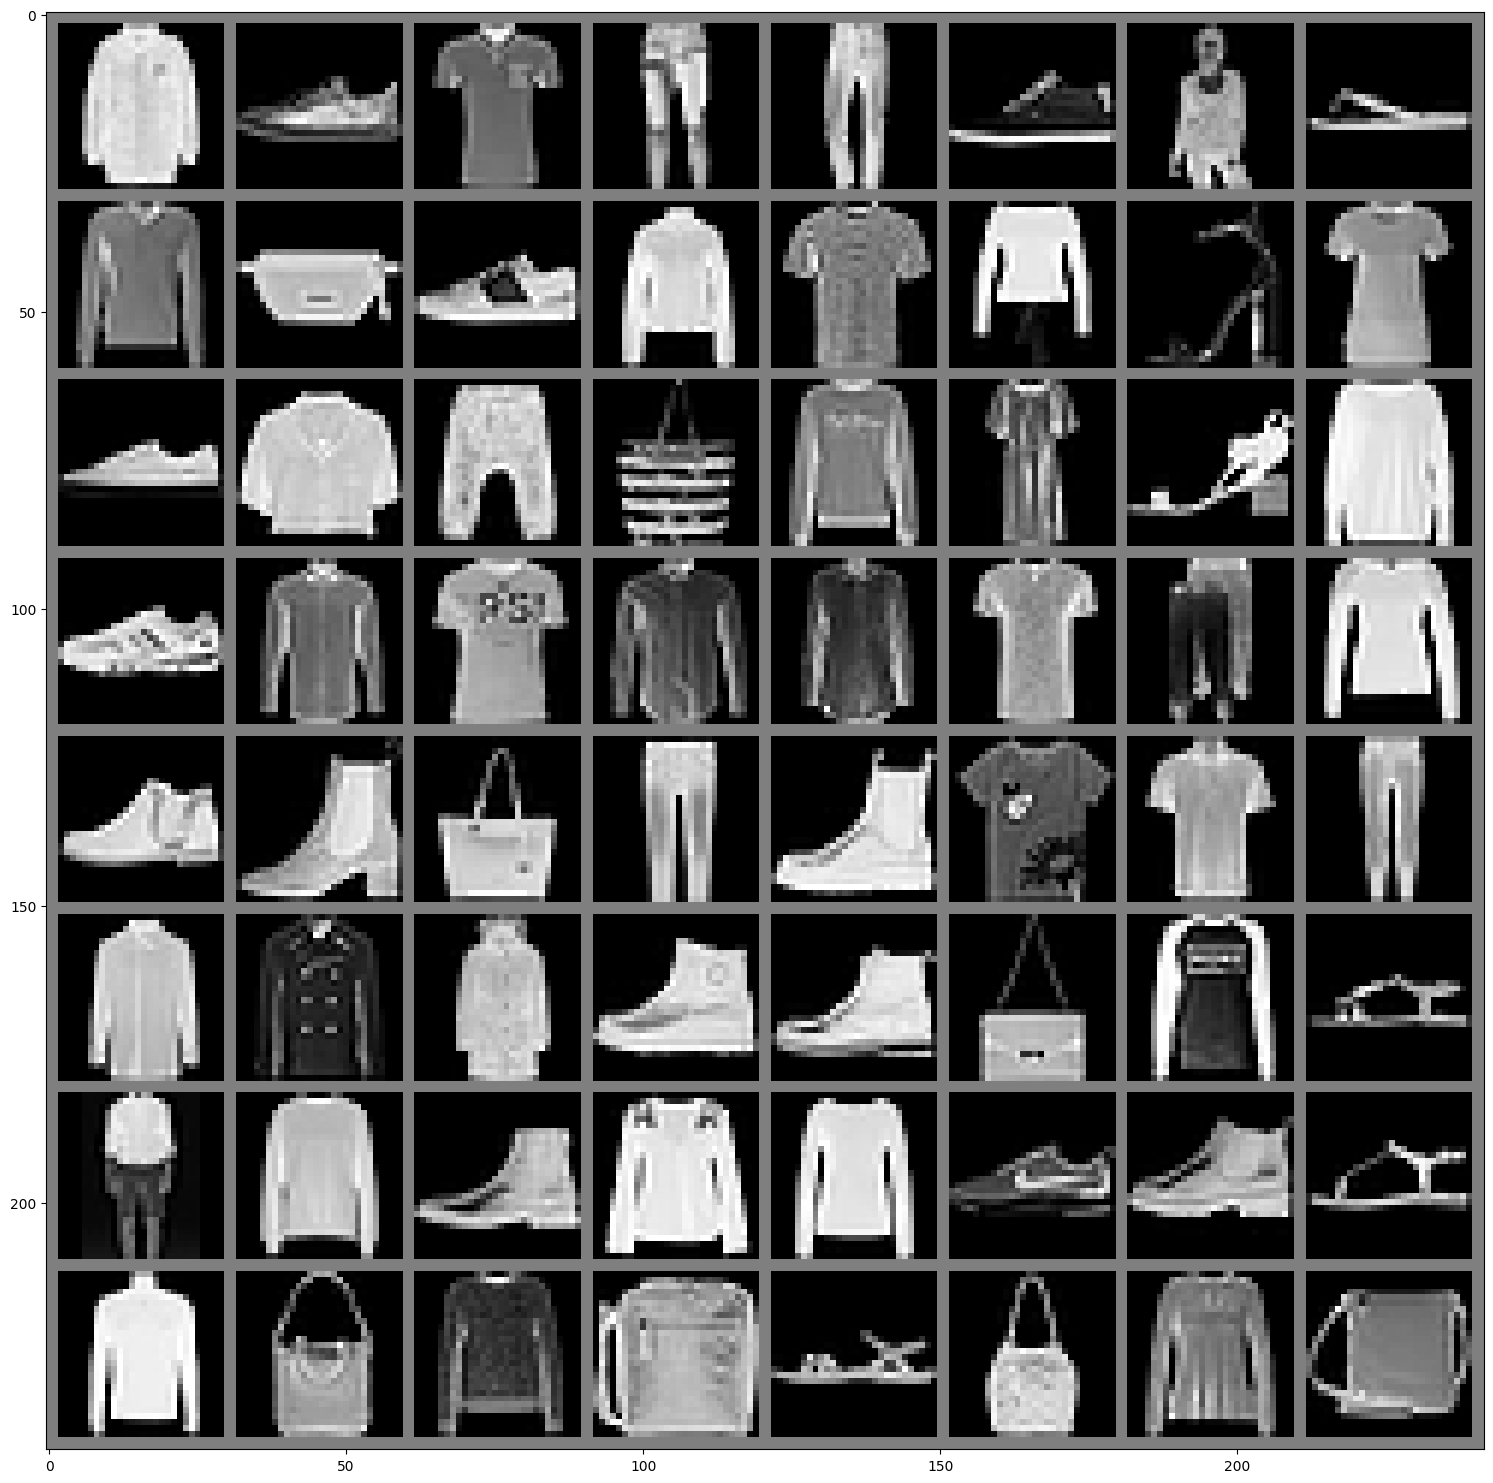

In [24]:
# Get a batch of training data
trainiterator = iter(train_loader)
images, label = trainiterator.next()

# Helper function to display a batch of images

def imshow(img):
    img = img / 2 + 0.5  # unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.tight_layout()
    plt.show()

# Show images
print("Sample images from the training set:")
plt.figure(figsize=(15,15))
imshow(make_grid(images))

In [25]:
# Print the shape of the training, validation, and test sets
print(f"Training set size: {len(train_dataset)} samples")
print(f"Validation set size: {len(val_dataset)} samples")
print(f"Test set size: {len(test_dataset)} samples")

# Print shape of a single batch of data
print(f"Shape of images batch (training set): {images.shape}")
print(f"Shape of labels batch (training set): {label.shape}")

Training set size: 54000 samples
Validation set size: 6000 samples
Test set size: 10000 samples
Shape of images batch (training set): torch.Size([64, 1, 28, 28])
Shape of labels batch (training set): torch.Size([64])



---

### Detailed Explanation of the **ImprovedTransformerLayer**:

The **ImprovedTransformerLayer** consists of key building blocks that enhance the transformer architecture with multi-head attention, feedforward layers, layer normalization, dropout, and residual connections. These components work together to ensure the model can effectively capture relationships within the data while maintaining stability during training. Below is a breakdown of how each component functions:

##### 1. **Multi-head Attention** (`self.attention`):
- **What it does**: 
  - The **multi-head attention mechanism** allows the model to focus on different parts of the input sequence simultaneously. This is crucial for understanding relationships between tokens (image patches, words, etc.) across the entire sequence.
  - **Self-attention** enables each token to attend to all other tokens in the sequence, learning which parts of the sequence are most important for each token. This gives the model the ability to capture both local and global dependencies.

- **Key Parameters**:
  - **`embedding_dim`**: This represents the dimensionality of each token's embedding. It defines the size of the vector that represents each token after the convolutional layers.
  - **`num_heads`**: Multi-head attention splits the attention mechanism into multiple "heads" (parallel attention computations). Each head learns different relationships between tokens, allowing the model to focus on multiple aspects of the data simultaneously. For example, one head might focus on nearby tokens, while another looks at more distant ones.

- **How it works**:
  - The input tensor `x` is passed through the multi-head attention layer, where each token in the sequence can "attend" to every other token. This is done using three matrices: **query**, **key**, and **value**, all derived from the input itself in self-attention.
  - The attention mechanism computes a weighted sum of the values, where the weights are determined by the query-key pairs.
  - The multi-head aspect enables multiple independent attention heads to capture diverse patterns in the data.
  
- **Dropout in Attention**:
  - Dropout is applied to the attention scores to prevent the model from relying too heavily on any specific connections during training. This helps with **regularization**, reducing overfitting, and making the model more robust to unseen data.

---

##### 2. **Residual Connections** and **Layer Normalization**:

- **Residual Connections**:
  - **What it does**: 
    - A **residual connection** adds the original input `x` back to the output of the attention or feed-forward layers. This direct connection helps maintain the original information while also incorporating the new transformations. 
    - Residual connections are crucial in deep models like transformers because they allow **gradients to flow more easily** during backpropagation, reducing the risk of vanishing gradients.
  - **Why it's important**:
    - As models get deeper, there is a risk of information loss or degradation through successive layers. Residual connections help mitigate this issue by ensuring that the original information is preserved.

- **Layer Normalization**:
  - **What it does**:
    - **Layer normalization** is applied after the attention and feedforward operations to stabilize the learning process. It normalizes the input so that it has a mean of 0 and a variance of 1, helping to maintain the stability of activations.
  - **Why it's important**:
    - Without normalization, the model’s activations could become too large or too small, which can slow down learning or cause instability. Normalization ensures that the data flows through the network in a more controlled and stable way, helping the model converge faster and reducing the risk of vanishing/exploding gradients.
  - **When it’s applied**: 
    - Layer normalization is applied **after** the residual connection, ensuring that the combined input and attention output are normalized before passing to the next layer.
  
---

##### 3. **Feedforward Network (FFN)** (`self.ff`):

- **What it does**:
  - The **feedforward network (FFN)** is a two-layer neural network applied independently to each token in the sequence. It helps the model learn more complex, non-linear representations after the attention mechanism.
  
- **How it works**:
  - The FFN consists of:
    1. **Linear Transformation** (`nn.Linear(embedding_dim, ff_dim)`): The first linear layer projects the input (of size `embedding_dim`) to a higher-dimensional space (`ff_dim`), allowing the model to capture more abstract and complex representations of the data.
    2. **ReLU Activation** (`nn.ReLU()`): The ReLU activation introduces non-linearity, allowing the model to learn more complex relationships.
    3. **Dropout** (`nn.Dropout(dropout)`): Dropout is applied after the ReLU to prevent overfitting by randomly dropping some of the neurons during training.
    4. **Second Linear Transformation** (`nn.Linear(ff_dim, embedding_dim)`): The second linear layer projects the data back to the original embedding dimension (`embedding_dim`), ensuring that the output can be processed further or used for residual connections.

- **Why it's important**:
  - The attention mechanism captures relationships between tokens, but the FFN helps the model capture higher-level patterns and enriches the representation of the data.
  - By applying the FFN to each token independently, the model can learn complex transformations for each token in the sequence.
  
---

##### 4. **Dropout** (`self.dropout`):

- **What it does**:
  - **Dropout** is applied at multiple points throughout the transformer layer to prevent overfitting and improve the model’s ability to generalize to unseen data.
  
- **How it works**:
  - Dropout works by randomly "dropping" (setting to zero) some of the neurons during each forward pass in training. This forces the model to learn more robust and distributed representations of the data, as it cannot rely too heavily on any specific neurons.
  - Dropout is applied in the following areas of the **ImprovedTransformerLayer**:
    1. **After the multi-head attention output**: Prevents overfitting by ensuring that the attention mechanism does not focus too much on any one particular token relationship.
    2. **Inside the FFN**: Ensures that the fully connected layers don’t overfit to specific patterns in the training data.
    3. **On residual connections**: Dropout is also applied after residual connections, further encouraging the model to learn more generalized features.

- **Why it's important**:
  - Dropout is especially important in deep learning models because it reduces overfitting, ensuring that the model does not memorize the training data. Instead, it forces the model to learn more generalized patterns, which are useful for making predictions on unseen data.

---

##### Summary of Improvements in the Transformer Layer:

- **Multi-head attention** allows the model to focus on multiple aspects of the sequence simultaneously, capturing both local and global relationships between tokens.
- **Residual connections** and **layer normalization** help maintain stability, allowing the model to train effectively by keeping gradients flowing and preventing the loss of information.
- The **feedforward network** further transforms the token representations, allowing for more complex pattern recognition in the data.
- **Dropout** is applied throughout the layer to ensure the model is not overfitting, improving generalization to unseen data.

The **ImprovedTransformerLayer** combines these components to create a powerful, robust, and scalable model block that can be used in deep models for processing sequences such as images (after convolutional tokenization) or text.

In [48]:
class ImprovedTransformerLayer(nn.Module):
    def __init__(self, embedding_dim, num_heads, ff_dim, dropout=0.3):
        super(ImprovedTransformerLayer, self).__init__()
        # Multi-head Attention Layer with Layer Normalization
        self.attention = nn.MultiheadAttention(embedding_dim, num_heads, dropout=dropout)
        self.norm1 = nn.LayerNorm(embedding_dim)
        
        # Feedforward Neural Network with Dropout and Layer Normalization
        self.ff = nn.Sequential(
            nn.Linear(embedding_dim, ff_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, embedding_dim),
        )
        self.norm2 = nn.LayerNorm(embedding_dim)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Multi-head Self Attention
        attn_output, _ = self.attention(x, x, x)
        x = x + self.dropout(attn_output)  # Residual connection
        x = self.norm1(x)  # Normalize after attention

        # Feedforward Network
        ff_output = self.ff(x)
        x = x + self.dropout(ff_output)  # Residual connection
        x = self.norm2(x)  # Normalize after feedforward

        return x

Sure! I'll add the detailed explanation of the **ImprovedTransformerLayer** to the main explanation as requested.

---

### Now we will build the **Compact Convolutional Transformer (CCT)** model
---

##### 1. **Convolutional Tokenization**:
  - To tokenize the image by extracting features. Extract features from the input images (28x28 size). The MaxPool2d layer reduces the size of the feature map to 14x14.
  - **In the Image**: The CCT architecture starts with a **Convolutional Tokenization** block, which consists of **4 convolutional layers** to process the image and extract important features.
  - **In the Code**: 
    ```python
    self.conv_layers = nn.Sequential(
        nn.Conv2d(input_channels, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(256, embedding_dim, kernel_size=3, padding=1),  # Fourth conv layer with embedding_dim=64
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)  # Downsampling the feature map
    )
    ```
  - **Explanation**: The model uses **four convolutional layers** (`nn.Conv2d`) to extract local features from the input image. The first three layers progressively increase the feature maps from 64 → 128 → 256, and the final layer reduces it to the `embedding_dim=64`. The output is downsampled using a pooling layer (`nn.MaxPool2d`) to reduce its spatial dimensions from 28x28 to 14x14, similar to how the convolutional tokenization is used in the architecture.

---

##### 2. **Reshape**:
  - **In the Image**: After the convolutional layers, the output feature maps are reshaped into a sequence that can be processed by the transformer.
  - **In the Code**: 
    ```python
    x = x.view(batch_size, embedding_dim, height * width)  # Shape: [batch_size, embedding_dim, 196]
    x = x.permute(0, 2, 1)  # Shape: [batch_size, 196, embedding_dim]
    ```
  - **Explanation**: The feature maps output by the convolutional layers (with shape `[batch_size, embedding_dim, height, width]`) are flattened into a 2D sequence of tokens (`[batch_size, num_tokens, embedding_dim]`), where each token represents a portion of the image. This prepares the data for the transformer encoder. In this case, **196 tokens** are created from the **14x14 feature map** (since `14 * 14 = 196`).

---

##### 3. **Positional Embedding** (Optional):
  - Helps the transformer encoder understand the position of each patch. It is added to the input sequence.
  - **In the Image**: The architecture shows the use of **optional positional embeddings**, which help the model understand the relative positions of different patches.
  - **In the Code**:
    ```python
    self.pos_embedding = nn.Parameter(torch.randn(1, (28 // 2)**2, embedding_dim))
    x += self.pos_embedding
    ```
  - **Explanation**: A learnable positional embedding (`self.pos_embedding`) is added to the token sequence to give the transformer a sense of where each token (patch) comes from in the image. This is optional and helps with positional awareness in the transformer. The embedding ensures the model knows the relative positions of the 196 tokens created from the 14x14 feature map.

---

##### 4. **Transformer Encoder**:
  - To model the global relationships. Consists of **multiple transformer encoder layers with multi-head attention** that processes the token sequence.
  - **In the Image**: The next block in the CCT architecture is the **Transformer Encoder**, which processes the sequence of tokens to capture global relationships between different parts of the image.
  - **In the Code**:
    ```python
    self.transformer_layers = nn.ModuleList([
        ImprovedTransformerLayer(embedding_dim, num_heads, ff_dim, dropout) 
        for _ in range(num_transformer_layers)
    ])
    for layer in self.transformer_layers:
        x = layer(x)
    ```
  - **Explanation**: The model uses a custom transformer encoder with **`num_transformer_layers`** layers of attention and feed-forward blocks (`ImprovedTransformerLayer`). This allows the model to understand how different parts (tokens) of the image are related to each other globally. Each transformer layer includes **multi-head self-attention**, **feedforward networks (FFN)**, **layer normalization**, **dropout**, and **residual connections**.

  ---
  
  ### Explanation of the **ImprovedTransformerLayer**:

  - **Multi-head Attention** (`self.attention`):
    - The `nn.MultiheadAttention` layer computes self-attention, allowing each token to attend to every other token in the sequence.
    - **`embedding_dim`** specifies the size of the token embeddings, and **`num_heads`** controls how many parallel attention mechanisms are used to capture different relationships.
    - Dropout is applied to the attention scores to help regularize the model and prevent overfitting.

  - **Residual Connections** and **Layer Normalization**:
    - After each attention and feed-forward operation, residual connections are used to add the input back to the output. This helps gradient flow during training and stabilizes learning.
    - **Layer normalization** is applied to normalize the output, ensuring that activations remain stable across layers.

  - **Feedforward Network** (`self.ff`):
    - The feedforward network consists of two linear transformations with a ReLU non-linearity in between. It projects the input from the embedding dimension to a higher-dimensional space (`ff_dim`), applies a ReLU activation, and then projects it back to the original embedding size.
    - Dropout is applied again after the feedforward layers to reduce overfitting.
  
  - **Dropout** (`self.dropout`):
    - Dropout is applied throughout the attention and feed-forward layers to prevent overfitting by randomly deactivating parts of the model during training.

---

##### 5. **Sequence Pooling**:
  - To combine the outputs of the transformer for classification. We use sequence pooling by averaging over all tokens (the patches) or flatten the whole sequence if pooling isn't used.
  - **In the Image**: The **Sequence Pooling** block gathers information from the entire sequence of tokens (the output of the transformer encoder) and pools them into a single representation.
  - **In the Code**:
    ```python
    if self.pooling == 'sequence':
      x = x.mean(dim=1)  # Sequence Pooling (average over all tokens)
    ```
  - **Explanation**: The code uses **sequence pooling**, where the output tokens from the transformer are averaged together (`x.mean(dim=1)`). This pooled representation is used to classify the entire image. Sequence pooling replaces the need for a separate class token (as used in ViT). This allows the model to summarize the information across all tokens and make a final prediction based on the entire image.

---

##### 6. **Linear Layer**:
  - **In the Image**: The final block in the architecture is a **linear layer** that produces the classification output (such as the class of clothing in the FashionMNIST dataset).
  - **In the Code**:
    ```python
    self.fc = nn.Linear(embedding_dim, num_classes)
    x = self.fc(x)
    ```
  - **Explanation**: The model outputs the final prediction using a fully connected layer (`nn.Linear`). The input to this layer is the pooled representation from the transformer, and it outputs a vector of size `num_classes` (10 classes for FashionMNIST). This is the final classification layer where the model predicts the class label based on the learned features.

---

##### 7. **Classification**:
  - The fully connected layer (fc) predicts the class label for the image.
  - **In the Code**:
    ```python
    x = self.fc(x)
    ```
  - **Explanation**: The final classification is done by a linear layer, which maps the transformed feature representations to the appropriate class label. For FashionMNIST, the model predicts one of 10 classes (such as "t-shirt", "shoe", etc.).

---

This explanation includes the detailed workings of the **ImprovedTransformerLayer** and how it fits within the CCT model. It covers the multi-head attention mechanism, feedforward layers, residual connections, and layer normalization in a clear and organized manner. It also explains the changes such as **4 convolutional layers**, **multi-head attention transformer layers**, and advanced techniques like **dropout** and **layer normalization**.


In [49]:
class CCT(nn.Module):
    def __init__(self, input_channels, num_classes, embedding_dim=64, num_heads=4, ff_dim=256, num_transformer_layers=4, dropout=0.3, pooling='sequence'):
        super(CCT, self).__init__()

        # Convolutional layers for feature extraction (4 layers)
        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, embedding_dim, kernel_size=3, padding=1),  # Fourth conv layer with embedding_dim=64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Downsampling the feature map
        )
        
        # Positional Embedding (Optional)
        self.pos_embedding = nn.Parameter(torch.randn(1, (28 // 2)**2, embedding_dim))

        # Transformer Encoder Layers
        self.transformer_layers = nn.ModuleList([
            ImprovedTransformerLayer(embedding_dim, num_heads, ff_dim, dropout) 
            for _ in range(num_transformer_layers)
        ])

        # Sequence Pooling or Global Pooling
        self.pooling = pooling
        if self.pooling == 'sequence':
            self.fc = nn.Linear(embedding_dim, num_classes)
        else:
            self.fc = nn.Linear((28 // 2) ** 2 * embedding_dim, num_classes)  # For global pooling

    def forward(self, x):
        # 1. Convolutional Feature Extraction
        x = self.conv_layers(x)  # Shape: [batch_size, embedding_dim, 14, 14]
        batch_size, embedding_dim, height, width = x.shape

        # 2. Flatten and Reshape for Transformer Input
        x = x.view(batch_size, embedding_dim, height * width)  # Shape: [batch_size, embedding_dim, 196]
        x = x.permute(0, 2, 1)  # Shape: [batch_size, 196, embedding_dim]

        # 3. Add Positional Embedding (optional)
        x += self.pos_embedding

        # 4. Transformer Encoder with multiple layers
        for layer in self.transformer_layers:
            x = layer(x)

        # 5. Pooling: Sequence or Global
        if self.pooling == 'sequence':
            x = x.mean(dim=1)  # Sequence Pooling (average over all tokens)
        else:
            x = x.flatten(1)  # Global Pooling (flattening the output)

        # 6. Classification
        x = self.fc(x)  # Shape: [batch_size, num_classes]
        return x


##### Summary of How Code Aligns with the CCT Architecture:

- **Convolutional Tokenization** in the image corresponds to the **convolutional layers** in the code.
- **Reshape** step is handled by reshaping the convolutional output into a token sequence.
- **Positional Embedding** is optional but helps the transformer know the positions of the image patches.
- **Transformer Encoder** is implemented as multiple layers of a transformer encoder to learn global relationships between tokens.
- **Sequence Pooling** averages the output tokens from the transformer, similar to the sequence pooling step in the architecture.
- The final **Linear Layer** classifies the image based on the pooled features.

This alignment ensures the model structure matches the CCT architecture you shared. Let me know if you need further clarification!

#### Training

In [43]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [50]:
# Initialize model, loss function and optimizer
model = CCT(input_channels=1, num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    # Training Phase
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    # Validation Phase
    model.eval()
    total_val_loss = 0
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {total_loss/len(train_loader):.4f}, Validation Loss: {total_val_loss/len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%')


Epoch [1/10], Training Loss: 0.9543, Validation Loss: 0.5104, Validation Accuracy: 80.40%
Epoch [2/10], Training Loss: 0.4158, Validation Loss: 0.3539, Validation Accuracy: 87.08%
Epoch [3/10], Training Loss: 0.3322, Validation Loss: 0.3299, Validation Accuracy: 87.72%
Epoch [4/10], Training Loss: 0.2842, Validation Loss: 0.2741, Validation Accuracy: 90.03%
Epoch [5/10], Training Loss: 0.2554, Validation Loss: 0.2637, Validation Accuracy: 90.53%
Epoch [6/10], Training Loss: 0.2340, Validation Loss: 0.2450, Validation Accuracy: 91.50%
Epoch [7/10], Training Loss: 0.2180, Validation Loss: 0.2435, Validation Accuracy: 91.03%
Epoch [8/10], Training Loss: 0.2014, Validation Loss: 0.2442, Validation Accuracy: 91.58%
Epoch [9/10], Training Loss: 0.1901, Validation Loss: 0.2291, Validation Accuracy: 91.92%
Epoch [10/10], Training Loss: 0.1780, Validation Loss: 0.2311, Validation Accuracy: 92.28%


##### **Explanation**:
- **Training Loop**: We loop through the dataset, perform a forward pass, compute the loss, and then perform backpropagation to update model weights.
- **Loss**: We use CrossEntropyLoss as it’s suitable for classification problems.
- **Optimizer**: We use Adam optimizer for its efficiency in convergence.